#Setting up the environment

In [ ]:
'''!pip uninstall -y pmdarima numpy
!pip install numpy==1.24.3
!pip install pmdarima --no-cache-dir'''

'!pip uninstall -y pmdarima numpy\n!pip install numpy==1.24.3\n!pip install pmdarima --no-cache-dir'

In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX # Corrected import
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from scipy.fft import fft, fftfreq
np.random.seed(0)

In [ ]:
def fft_analysis(signal):
  slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
  trend = np.arange(len(signal))*slope + intercept
  detrended = signal - trend

  fft_values = fft(detrended)
  frequencies = np.fft.fftfreq(len(fft_values))

  positive_frequencies = frequencies[frequencies>0]
  magnitudes = np.abs(fft_values)[frequencies>0]

  dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
  print(f"Dominant Frequency: {dominant_frequency:.3f}")

  dominant_period = 1/dominant_frequency
  print(f"Dominant Period: {dominant_period:.2f} time units")

  return dominant_period, positive_frequencies, magnitudes


In [ ]:
data = pd.read_csv('time_data.csv')
data

,Id,Values
0,0,2.834420
1,1,4.279164
2,2,1.598206
3,3,0.069473
4,4,0.232714
...,...,...
796,796,286.592993
797,797,286.195649
798,798,285.752718
799,799,287.831402


In [ ]:
data.set_index('Id', inplace=True)
data

,Values
Id,
0,2.834420
1,4.279164
2,1.598206
3,0.069473
4,0.232714
...,...
796,286.592993
797,286.195649
798,285.752718


In [ ]:
train_data = data.iloc[:int(len(data)*0.8)]
test_data = data.iloc[int(len(data)*0.8):]

In [ ]:
out = fft_analysis(train_data.iloc[0:200]['Values'])

Dominant Frequency: 0.085
Dominant Period: 11.76 time units


<Axes: xlabel='Id'>

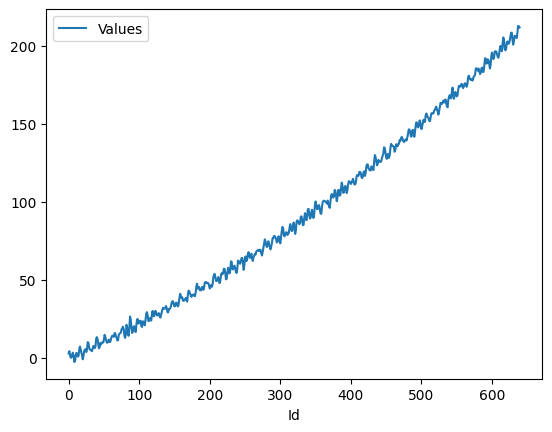

In [ ]:
train_data.plot()

In [ ]:
out = adfuller(train_data['Values'])
print('ADF Statistic: %f' % out[0])
print('p-value: %f' % out[1])
for key, value in out[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 11.796410
p-value: 1.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


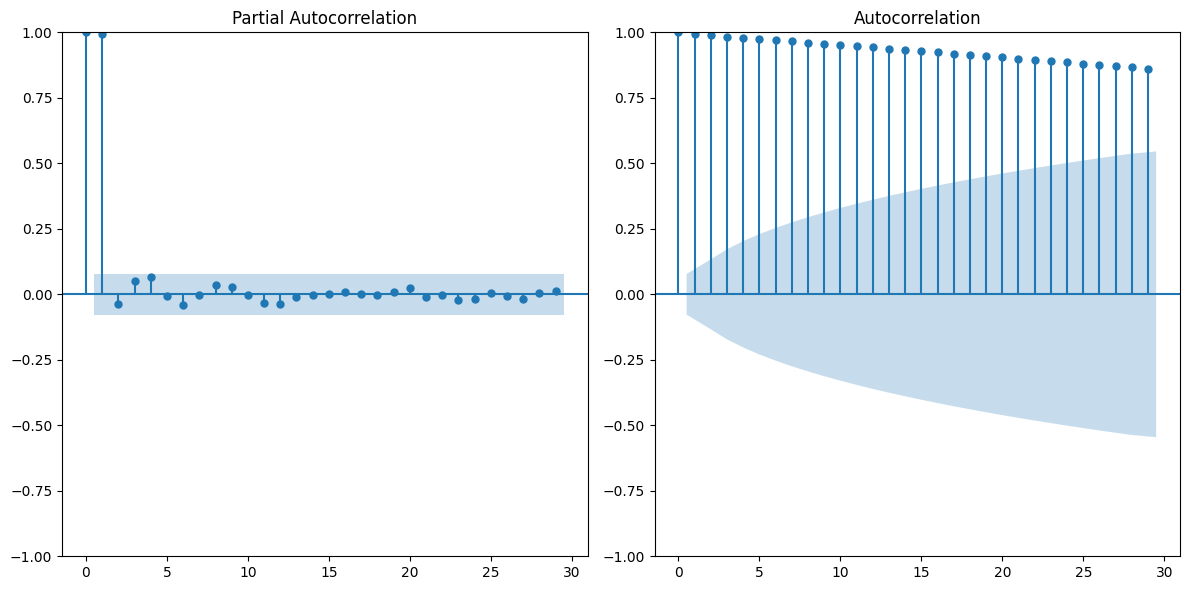

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_pacf(train_data['Values'], ax=ax[0])
plot_acf(train_data['Values'], ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
decomposition = seasonal_decompose(train_data['Values'], model='additive', period=12)
seasonal = decomposition.seasonal
tr = train_data['Values'] - seasonal
tr.head()

,0
Id,
0,3.222873
1,3.527865
2,-0.270101
3,-2.399960
4,-1.622402


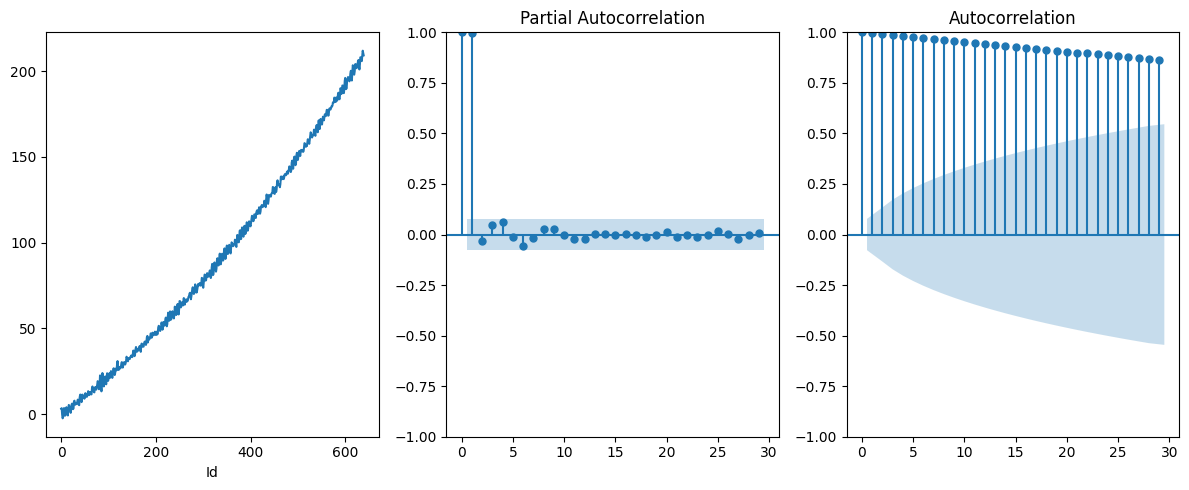

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
tr.plot(ax=ax[0])
plot_pacf(tr, ax=ax[1])
plot_acf(tr, ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
process = train_data.copy()

In [ ]:
out = adfuller(process['Values'])
print('ADF Statistic: %f' % out[0])
print('p-value: %f' % out[1])
for key, value in out[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 11.796410
p-value: 1.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [ ]:
decomposition = seasonal_decompose(process['Values'].dropna(), model='additive', period=12)
seasonal = decomposition.seasonal
tr = process['Values'] - seasonal
tr.dropna(inplace=True)
tr.head()

,0
Id,
0,3.222873
1,3.527865
2,-0.270101
3,-2.399960
4,-1.622402


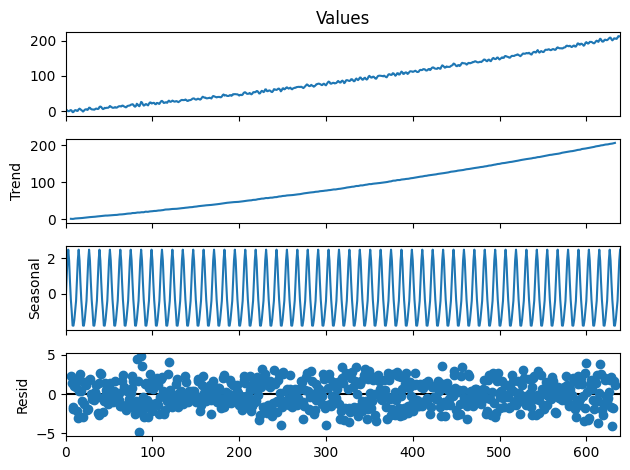

In [ ]:
decomposition.plot();

In [ ]:
out = adfuller(tr)
print('ADF Statistic: %f' % out[0])
print('p-value: %f' % out[1])
for key, value in out[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 8.929851
p-value: 1.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [ ]:
tr = tr.diff().dropna()

In [ ]:
out = adfuller(tr.dropna())
print('ADF Statistic: %f' % out[0])
print('p-value: %f' % out[1])
for key, value in out[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.140160
p-value: 0.000831
	1%: -3.441
	5%: -2.866
	10%: -2.569


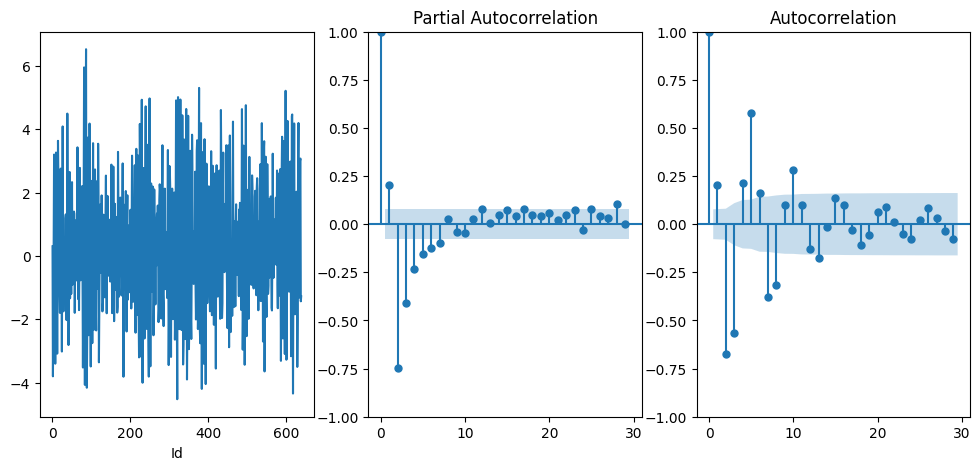

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
tr.plot(ax=ax[0])
plot_pacf(tr, ax=ax[1])
plot_acf(tr, ax=ax[2])
plt.show();

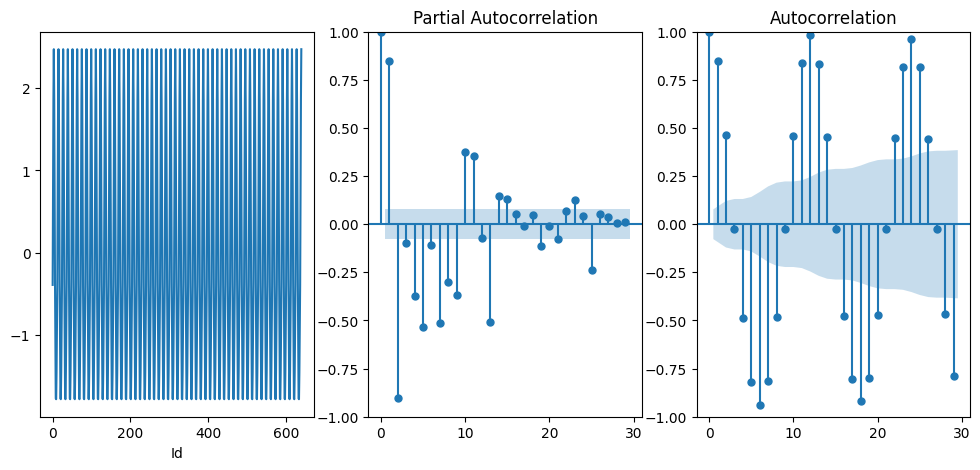

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
seasonal.plot(ax=ax[0])
plot_pacf(seasonal, ax=ax[1])
plot_acf(seasonal, ax=ax[2])
plt.show();

In [ ]:
out = adfuller(seasonal.dropna())
print('ADF Statistic: %f' % out[0])
print('p-value: %f' % out[1])
for key, value in out[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -312950858164238.750000
p-value: 0.000000
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [ ]:
'''model = pm.auto_arima(train_data,
                       start_p=2, start_q=1,
                       test='adf',
                       max_p=4, max_q=1, m=12,
                       start_P=0, start_Q=0,
                       max_P=1, max_Q=1,
                       seasonal=True,
                       d=1,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       trend='ct',
                       suppress_warnings=True,
                       stepwise=True)'''

"model = pm.auto_arima(train_data,\n                       start_p=2, start_q=1,\n                       test='adf',\n                       max_p=4, max_q=1, m=12,\n                       start_P=0, start_Q=0,\n                       max_P=1, max_Q=1,\n                       seasonal=True,\n                       d=1,\n                       D=1,\n                       trace=True,\n                       error_action='ignore',\n                       trend='ct',\n                       suppress_warnings=True,\n                       stepwise=True)"

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

n = len(train_data)
x = np.arange(n)
exog_train = np.column_stack([x, x**2])


In [ ]:
model = SARIMAX(train_data,
                order=(2,1,1),
                seasonal_order=(0,1,1,12),
                exog=exog_train)

model_fit = model.fit(disp=False)

In [ ]:
h = len(test_data)
future_x = np.arange(n, n + h)
exog_test = np.column_stack([future_x, future_x**2])

In [ ]:
forecast = model_fit.predict(start=n, end=n+h-1, exog=exog_test)
noise = np.random.normal(0, 0.1, len(forecast))
forecast_noisy = forecast+noise

In [ ]:
mse = mean_squared_error(test_data, forecast_noisy)
print(f"Forecast MSE: {mse:.3f}")

Forecast MSE: 4.763


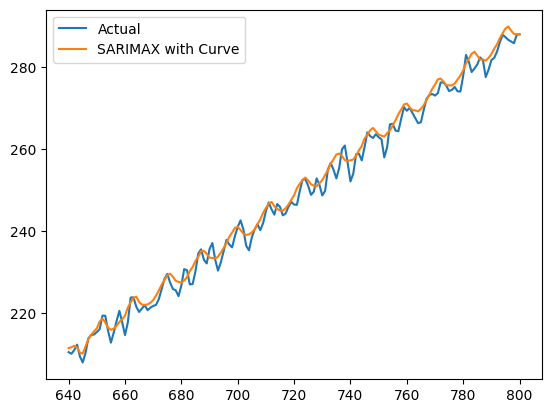

In [ ]:
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, forecast_noisy, label='SARIMAX with Curve')
plt.legend()
plt.show()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Values   No. Observations:                  640
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1044.362
Date:                            Sun, 20 Jul 2025   AIC                           2102.724
Time:                                    13:14:21   BIC                           2133.811
Sample:                                         0   HQIC                          2114.802
                                            - 640                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.357e-14   3.13e-09   1.71e-05      1.000   -6.14e-09    6.14e-09
x2             0.0002      0.000      1.647      0.100   -3.92e-05       0.000
ar.L1          0.5941      0.049     12.058      0.000       0.498       0.691
ar.L2         -0.8414      0.044    -18.922      0.000      -0.929      -0.754
ma.L1         -0.5982      0.079     -7.605      0.000      -0.752      -0.444
ma.S.L12      -0.9198      0.048    -19.087      0.000      -1.014      -0.825
sigma2         2.5075      0.236     10.623      0.000       2.045       2.970
===================================================================================
Ljung-Box (L1) (Q):                  22.96   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):               1.03   Skew:                             0.07
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.65e+23. Standard errors may be unstable.
"""

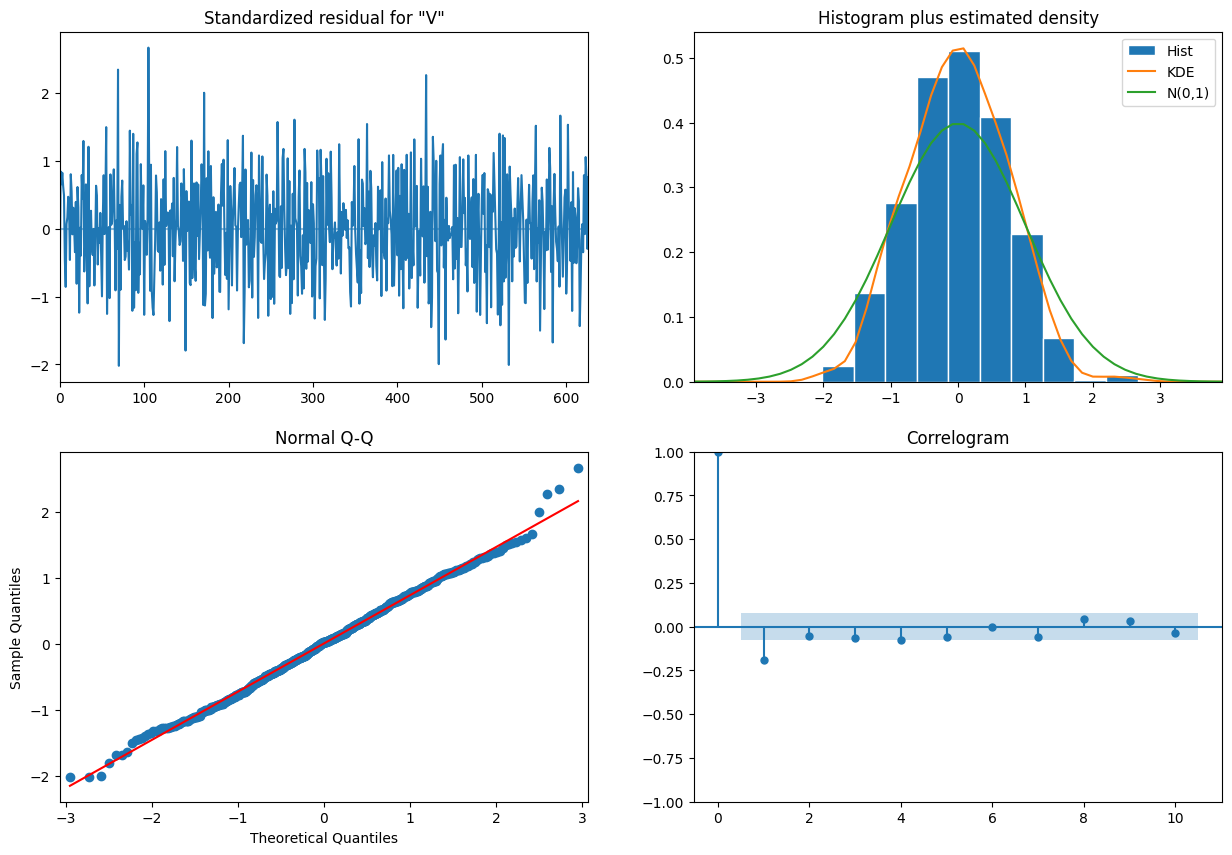

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 10));

In [ ]:
n_steps = len(test_data)
start_index = len(train_data)
end_index = start_index + n_steps - 1
forecast = model_fit.predict(start=start_index, end=end_index, exog=exog_test)
forecast

,predicted_mean
640,211.347815
641,211.684269
642,211.974666
643,211.445199
644,210.203148
...,...
796,289.735604
797,288.958890
798,288.158189
799,287.997108


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(forecast, test_data['Values'])
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4.732093016900805


<Axes: >

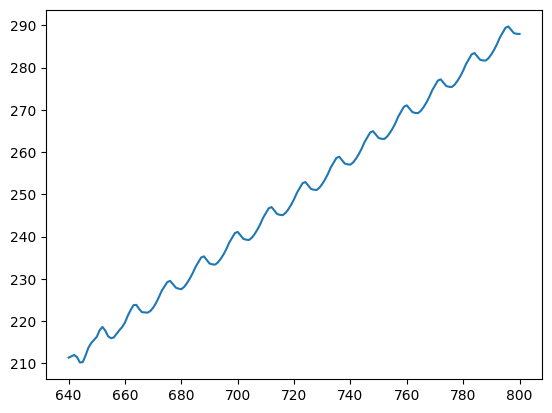

In [ ]:
residuals = test_data - forecast
residuals.dropna(inplace=True)
forecast.plot()

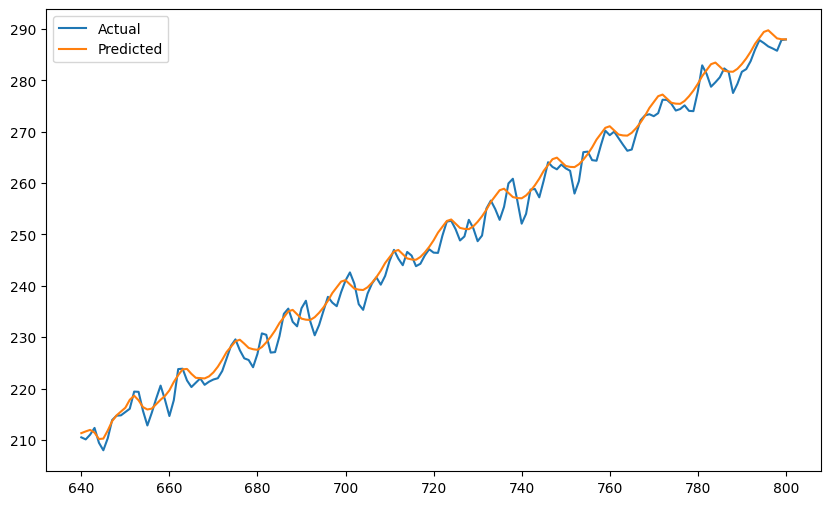

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(test_data['Values'])
plt.plot(forecast)
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
n = len(data)
x = np.arange(n)
exog = np.column_stack([x, x**2])
model = SARIMAX(data, order=(2,1,1), seasonal_order=(0,1,1,12), exog=exog)
result = model.fit(disp=False)

h = 199
future_x = np.arange(n, n + h)
exog_future = np.column_stack([future_x, future_x**2])
forecast = result.forecast(steps=h, exog=exog_future)
noise = np.random.normal(0, 0.25, len(forecast))
forecast = forecast+noise
forecast

,predicted_mean
801,287.285540
802,286.521671
803,287.695603
804,290.252651
805,293.094809
...,...
995,395.875473
996,396.718653
997,398.844627
998,400.361502


In [ ]:
forecast.index.name = 'Id'
forecast.name = 'Values'
forecast

,Values
Id,
801,287.285540
802,286.521671
803,287.695603
804,290.252651
805,293.094809
...,...
995,395.875473
996,396.718653
997,398.844627


#To csv

In [ ]:
forecast.to_csv('(2,1,1)(0, 1, 1)_exog_254.csv')